In [6]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS

from library import print_statistics
from library import start

In [7]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [8]:
def bonferroni(n_tests, coef, pvalue):
    coef = round(coef, 2)
    if pvalue >(.05/n_tests):
        coef = str(coef)
    if pvalue <= (.05/n_tests):
        coef = str(coef) + '*'
    if pvalue <= (.01/n_tests):
        coef = coef + '*'
    if pvalue <= (.001/n_tests):
        coef = coef + '*'
    return(coef)
test = bonferroni(4, .1, .005)
test

'0.1*'

In [9]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [10]:
data = pd.read_csv(os.path.join(start.data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data.sample()

794


,Unnamed: 0,district,campus,year,test,score,score_std,campname,campischarter,distname,...,pre4,pre3,pre2,pre1,post1,post2,post3,test_by_year,math,reading
187553,213740,19910,19910101,2017,r_6th_avescore,1653.0,1.09518,MALTA EL,N,MALTA ISD,...,0,0,0,0,1,0,0,r_6th_avescore2017,0,1


In [8]:
subjects = ['m_3rd_avescore', 'm_4th_avescore',  'm_5th_avescore', 
            'm_6th_avescore', 'm_7th_avescore', 'm_8th_avescore',
            'alg_avescore',
            'r_3rd_avescore', 'r_4th_avescore', 'r_5th_avescore',
            'r_6th_avescore', 'r_7th_avescore', 'r_8th_avescore',
            'eng1_avescore',  'bio_avescore']
math_tests = ['m_3rd_avescore', 'm_4th_avescore', 'm_5th_avescore',
              'm_6th_avescore', 'm_7th_avescore', 'm_8th_avescore', 'alg_avescore']
reading_tests = ['r_3rd_avescore', 'r_4th_avescore', 'r_5th_avescore',
              'r_6th_avescore', 'r_7th_avescore', 'r_8th_avescore', 'eng1_avescore']

In [9]:
#convert year to datetime
df = data.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = df.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5, random_state = 8)

,,district,doi_year,treatpost
campus,year,,,
101914042,2019-01-01,101914,2018.0,True
57905049,2016-01-01,57905,2018.0,False
243903041,2017-01-01,243903,2018.0,False
170902118,2018-01-01,170902,2017.0,True
227901112,2016-01-01,227901,2017.0,False


# Specifications

In [10]:
    gdid_model = 'score_std ~ + 1 + treatpost  + C(test_by_year) + EntityEffects'
    linear_gdid_model = 'score_std ~ + 1 + treatpost + yearpost + yearpre + C(test_by_year) + EntityEffects'
    event_study_model = 'score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + C(test_by_year) + EntityEffects'

In [13]:
def results_table(data, file_name):    
    file = table_path + file_name
    wb = load_workbook(file)
    ws = wb.active
    
    # GDID
    mod = PanelOLS.from_formula(gdid_model, data)
    res = mod.fit(cov_type='clustered', clusters = data.district)
    #res = mod.fit(cov_type='clustered', cluster_entity = True, cluster_time = True)
    print(res)
    ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
    
    # Linear GDID
    mod = PanelOLS.from_formula(linear_gdid_model, data)
    res = mod.fit(cov_type='clustered', clusters = data.district)
    print(res)
    ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
    ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['yearpost'])
    ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
    ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['yearpre'])
    ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
    
    # Event Study
    mod = PanelOLS.from_formula(event_study_model, data)
    res = mod.fit(cov_type='clustered', clusters= data.district)
    print(res)
    row = 3
    for coef in ['post3', 'post2', 'post1', 'pre2', 'pre3', 'pre4', 'pre5']:
        ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
        row = row + 1
        ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
        row = row + 1    
    
    wb.save(file)

# Results

In [14]:
results_table(df[df.math == 1], 'table3_gdid_and_event_math.xlsx')

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2323
Estimator:                   PanelOLS   R-squared (Between):             -0.4637
No. Observations:              125638   R-squared (Within):               0.2323
Date:                Sun, Feb 16 2020   R-squared (Overall):             -0.0561
Time:                        21:21:34   Log-likelihood                -9.665e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      646.51
Entities:                        5961   P-value                           0.0000
Avg Obs:                       21.077   Distribution:               F(56,119634)
Min Obs:                       0.0000                                           
Max Obs:                       56.000   F-statistic (robust):             131.14
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2331
Estimator:                   PanelOLS   R-squared (Between):             -0.4670
No. Observations:              125638   R-squared (Within):               0.2331
Date:                Sun, Feb 16 2020   R-squared (Overall):             -0.0583
Time:                        21:21:36   Log-likelihood                -9.659e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      626.82
Entities:                        5961   P-value                           0.0000
Avg Obs:                       21.077   Distribution:               F(58,119632)
Min Obs:                       0.0000                                           
Max Obs:                       56.000   F-statistic (robust):             124.17
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2332
Estimator:                   PanelOLS   R-squared (Between):             -0.4670
No. Observations:              125638   R-squared (Within):               0.2332
Date:                Sun, Feb 16 2020   R-squared (Overall):             -0.0583
Time:                        21:21:40   Log-likelihood                -9.658e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      586.67
Entities:                        5961   P-value                           0.0000
Avg Obs:                       21.077   Distribution:               F(62,119628)
Min Obs:                       0.0000                                           
Max Obs:                       56.000   F-statistic (robust):             119.17
                            

In [103]:
results_table(df[df.reading == 1], 'table4_gdid_and_event_reading.xlsx')

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1264
Estimator:                   PanelOLS   R-squared (Between):             -0.1468
No. Observations:              118046   R-squared (Within):               0.1264
Date:                Tue, Jan 07 2020   R-squared (Overall):             -0.0250
Time:                        15:50:40   Log-likelihood                -6.867e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      289.40
Entities:                        5961   P-value                           0.0000
Avg Obs:                       19.803   Distribution:               F(56,112038)
Min Obs:                       0.0000                                           
Max Obs:                       56.000   F-statistic (robust):             259.90
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1264
Estimator:                   PanelOLS   R-squared (Between):             -0.1471
No. Observations:              118046   R-squared (Within):               0.1264
Date:                Tue, Jan 07 2020   R-squared (Overall):             -0.0252
Time:                        15:50:47   Log-likelihood                -6.867e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      279.51
Entities:                        5961   P-value                           0.0000
Avg Obs:                       19.803   Distribution:               F(58,112036)
Min Obs:                       0.0000                                           
Max Obs:                       56.000   F-statistic (robust):             260.24
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1265
Estimator:                   PanelOLS   R-squared (Between):             -0.1472
No. Observations:              118046   R-squared (Within):               0.1265
Date:                Tue, Jan 07 2020   R-squared (Overall):             -0.0253
Time:                        15:50:54   Log-likelihood                -6.866e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      261.63
Entities:                        5961   P-value                           0.0000
Avg Obs:                       19.803   Distribution:               F(62,112032)
Min Obs:                       0.0000                                           
Max Obs:                       56.000   F-statistic (robust):             245.02
                            

# Create event study graph

## Math

In [104]:
mod = PanelOLS.from_formula(event_study_model, df[df.math == 1])
res = mod.fit(cov_type='clustered', clusters=df[df.math ==1].district)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre1':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1, 1, 2, 3]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df['errsig'] = coef_df.err *1.96

fig, ax = plt.subplots(figsize=(8, 5))

coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='errsig', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2', 'Post3'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

fig.savefig(table_path + 'math_event_study' + '.png', bbox_inches="tight")

,coef,err,year,lb,ub,errsig
0,-0.005462,0.056915,-5,-0.117016,0.106092,0.111554
1,0.007922,0.050258,-4,-0.090584,0.106428,0.098506
2,0.018954,0.038786,-3,-0.057067,0.094974,0.076020
3,0.007155,0.021254,-2,-0.034503,0.048813,0.041658
4,0.000000,0.000000,-1,0.000000,0.000000,0.000000
5,-0.043976,0.026741,1,-0.096388,0.008436,0.052412
6,-0.097263,0.053381,2,-0.201890,0.007363,0.104627
7,-0.179492,0.091498,3,-0.358827,-0.000156,0.179336


## Reading

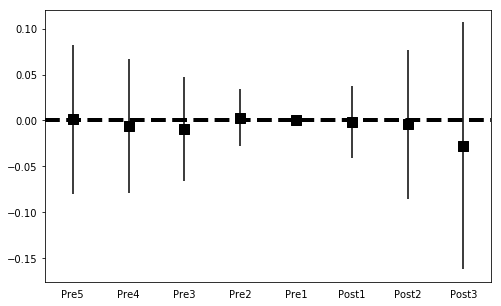

In [106]:
mod = PanelOLS.from_formula(event_study_model, df[df.reading == 1])
res = mod.fit(cov_type='clustered', clusters=df[df.reading ==1].district)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre1':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1, 1, 2, 3]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df['errsig'] = coef_df.err *1.96

fig, ax = plt.subplots(figsize=(8, 5))

coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='errsig', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2', 'Post3'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

fig.savefig(table_path + 'reading_event_study' + '.png', bbox_inches="tight")

# Table by Subject

In [110]:
# All Subject Table
file = table_path + 'tableA_effect_by_subject.xlsx'
wb = load_workbook(file)
ws = wb.active

col = 3
for subject in subjects:
    
    df_sub = df[df.test == subject]
    test = pd.Categorical(df_sub.test)
    
    # GDID
    mod = PanelOLS.from_formula(gdid_model, df_sub)
    res = mod.fit(cov_type='clustered', clusters = df_sub.district)
    ws.cell(row= 5, column= col).value = bonferroni(len(subjects), res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 6, column= col).value = format_se(res.std_errors['treatpost[T.True]'])

    # GDID with Trend
    mod = PanelOLS.from_formula(linear_gdid_model, df_sub)
    #mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', clusters = df_sub.district)
    jump = res.params['treatpost[T.True]']
    preslope = res.params['yearpre']
    preslope_se = res.std_errors['yearpre']
    postslope = res.params['yearpost']
    post_slope = res.std_errors['yearpost']
    ws.cell(row= 8, column= col).value = bonferroni(len(subjects), res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 9, column= col).value = format_se(res.std_errors['treatpost[T.True]'])
    ws.cell(row= 10, column= col).value = bonferroni(len(subjects), res.params['yearpost'], res.pvalues['yearpost'])
    ws.cell(row= 11, column= col).value = format_se(res.std_errors['yearpost'])
    ws.cell(row= 12, column= col).value = bonferroni(len(subjects), res.params['yearpre'], res.pvalues['yearpre'])
    ws.cell(row= 13, column= col).value = format_se(res.std_errors['yearpre'])
    wb.save(file)

    # Event Study
    mod = PanelOLS.from_formula(event_study_model, df_sub)
    res = mod.fit(cov_type='clustered', clusters=df_sub.district)
    nonparametric = []
    nonparametric_se = []
    for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'post1', 'post2', 'post3']:
        nonpar = 0
        nonpar_se = 0
        if coef != 'pre1':
            nonpar = res.params[coef]
            nonpar_se = res.std_errors[coef]
        nonparametric.append(nonpar)
        nonparametric_se.append(nonpar_se)
    row = 15
    for coef in ['post3', 'post2', 'post1', 'pre2', 'pre3', 'pre4', 'pre5']:
        ws.cell(row= row, column = col).value = coef_with_stars(res.params[coef], res.pvalues[coef])
        row = row + 1
        ws.cell(row= row, column = col).value = format_se(res.std_errors[coef])  
        row = row + 1
    col = col + 1
wb.save(file)


### 8th Grade reading fails specification tests. Check results without it. 

In [12]:
results_table(df[(df.reading == 1) & (df.test != 'r_8th_avescore')], 'tableA_gdid_and_event_reading_no8th.xlsx')

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1197
Estimator:                   PanelOLS   R-squared (Between):             -0.1386
No. Observations:              107007   R-squared (Within):               0.1197
Date:                Mon, Jan 13 2020   R-squared (Overall):             -0.0206
Time:                        11:45:04   Log-likelihood                -6.242e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      286.21
Entities:                        5961   P-value                           0.0000
Avg Obs:                       17.951   Distribution:               F(48,101013)
Min Obs:                       0.0000                                           
Max Obs:                       48.000   F-statistic (robust):             272.80
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1199
Estimator:                   PanelOLS   R-squared (Between):             -0.1392
No. Observations:              107007   R-squared (Within):               0.1199
Date:                Mon, Jan 13 2020   R-squared (Overall):             -0.0210
Time:                        11:45:10   Log-likelihood                -6.241e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      254.75
Entities:                        5961   P-value                           0.0000
Avg Obs:                       17.951   Distribution:               F(54,101007)
Min Obs:                       0.0000                                           
Max Obs:                       48.000   F-statistic (robust):             248.98
                            